![Machine Learning Live](images/title-slide.png "Title")

In [3]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# predict an output based on known inputs

* rate/demand forecasts
* probability of things like fraud or conversions
* package delivery times
* medical, eg: mortality rates for risk groups
* insurance risk
* operations/monitoring

## traditional rules

~~~~
                   rules
                     ||
                     \/
             ----------------
 input ====> |  algorithm   |  =====> output
             ----------------
~~~~

## With Machine Learning

~~~~
                    data
                     ||
                     \/
             ----------------
 input ====> |   ML model   |  =====> output
             ----------------
~~~~

# Why Taxi Fares?

The city of [New York published a dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) with taxi > 150M rides per year since 2009. This makes it a great dataset for training because:

* one can easily relate to the data (we have all used taxis before)
* simple enough, one table with a handful of columns
* large enough to do relevant machine learning
* there are lots of blogs, notebooks etc from others about all aspects of this data

# NYC Taxi fares

Sounds easy enough to do with rules:

* initial charge \$2.50
* \$0.40 per 1/5 mile
* \$0.40 per 1 minute stopped/slow traffic
* \$1.00 Weekday Surcharge 4pm-8pm
* \$0.50 Night Surcharge 8pm-6am

But to calculate this before a trip you need to already know the route time and distance. We will use this route from LGA to midtown Manhattan as an example and you can see that there are different route options with different estimated times and mileages. These also vary highly with the amount of traffic over the course of a day.

![sample route LGA to midtown](images/sample_route.png "Sample Route")

# A quick look at the data

The dataset that we will use is a public data and conveniently available at several locations, including a <a href="https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips">BigQuery public dataset</a>. 

Let's write a SQL query to poke around.

In [4]:
%sql --module afewrecords
SELECT pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude,
dropoff_latitude, passenger_count, trip_distance, tolls_amount, 
fare_amount, total_amount FROM [nyc-tlc:yellow.trips] LIMIT 10

In [5]:
trips = bq.Query(afewrecords).to_dataframe()
trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2010-03-04 00:35:16,-74.035201,40.721548,-74.035201,40.721548,1,0.0,0.0,0.0,0.0
1,2010-03-15 17:18:34,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0.0
2,2015-03-18 01:07:02,0.000000,0.000000,0.000000,0.000000,5,0.0,0.0,0.0,0.0
3,2015-03-09 18:24:03,-73.937248,40.758202,-73.937263,40.758190,1,0.0,0.0,0.0,0.0
4,2010-03-06 06:33:41,-73.785514,40.645400,-73.784564,40.648681,2,4.1,0.0,0.0,0.0
5,2013-08-07 00:42:45,-74.025817,40.763044,-74.046752,40.783240,1,4.8,0.0,0.0,0.0
6,2015-04-26 02:56:37,-73.987656,40.771656,-73.987556,40.771751,1,0.0,0.0,0.0,0.0
7,2015-04-29 18:45:03,0.000000,0.000000,0.000000,0.000000,1,1.0,0.0,0.0,0.0
8,2010-03-11 21:24:48,-74.571511,40.910800,-74.628928,40.964321,1,68.4,0.0,0.0,0.0
9,2013-08-24 01:58:23,-73.972171,40.759439,0.000000,0.000000,4,0.0,0.0,0.0,0.0


# What to do with this dataset?

* reporting
* analytics and exploration
* predictive analytics

But first we should do some data wrangling to improve the quality of the dataset we work with.

Let's increase the number of records so that we can do some neat graphs. There is no guarantee about the order in which records are returned, and so no guarantee about which records get returned if we simply increase the LIMIT. To properly sample the dataset, let's use the HASH of the pickup time and return 1 in 100,000 records -- because there are 1 billion records in the data, we should get back approximately 10,000 records if we do this.

In [8]:
%sql --module afewrecords2
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  ABS(HASH(pickup_datetime)) % $EVERY_N == 1

In [9]:
trips = bq.Query(afewrecords2, EVERY_N=100000).to_dataframe()
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2012-09-05 15:45:00,-74.005060,40.740822,-73.991710,40.740013,1,1.06,0.0,7.0,9.60
1,2014-07-20 02:20:38,-73.989582,40.720431,-74.004260,40.722064,4,1.40,0.0,8.0,9.00
2,2011-09-28 21:18:00,-73.999112,40.728132,-73.997970,40.729373,2,0.14,0.0,2.9,3.90
3,2012-08-07 15:57:00,-73.975525,40.749587,-73.982450,40.748455,1,1.11,0.0,7.3,9.26
4,2012-05-03 02:10:13,-73.978615,40.762481,-73.971330,40.761918,1,0.40,0.0,3.3,4.30
5,2011-08-22 15:55:00,-73.980255,40.734427,-73.976530,40.739457,1,0.40,0.0,3.3,3.80
6,2009-02-16 11:54:00,-74.001587,40.730930,-73.991095,40.736888,1,1.06,0.0,6.1,6.10
7,2011-01-07 15:16:00,-73.912302,40.634552,-73.912302,40.634552,1,0.72,0.0,4.5,5.00
8,2011-08-22 15:55:00,-73.955008,40.785930,-73.967737,40.798777,5,1.48,0.0,6.5,8.00
9,2014-01-02 15:00:36,-73.981458,40.767420,-73.974968,40.759205,1,0.80,0.0,7.5,8.00


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. We'll use the Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering.

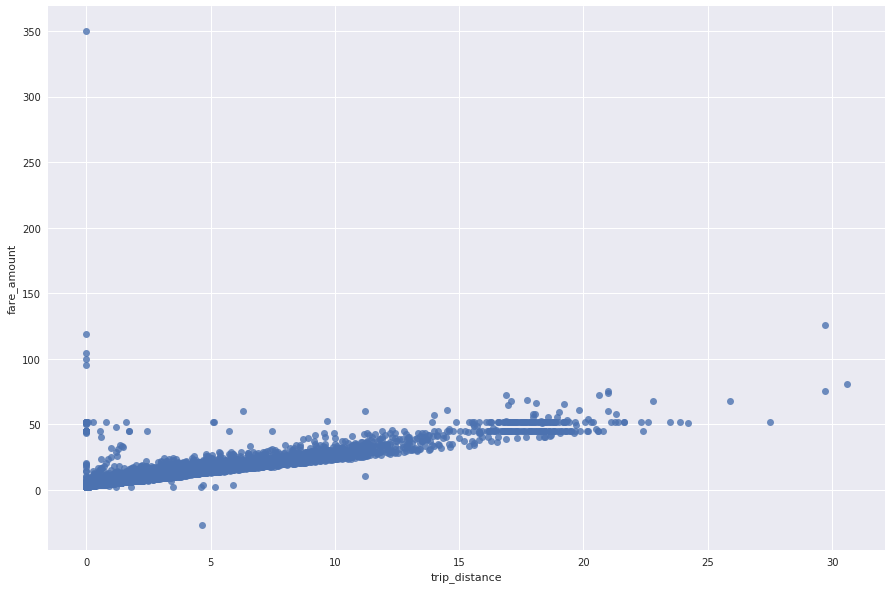

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

In [11]:
%sql --module afewrecords3
SELECT
  pickup_datetime,
  pickup_longitude, pickup_latitude, 
  dropoff_longitude, dropoff_latitude,
  passenger_count,
  trip_distance,
  tolls_amount,
  fare_amount,
  total_amount
FROM
  [nyc-tlc:yellow.trips]
WHERE
  (ABS(HASH(pickup_datetime)) % $EVERY_N == 1 AND
  trip_distance > 0 AND fare_amount >= 2.5 AND fare_amount <120)

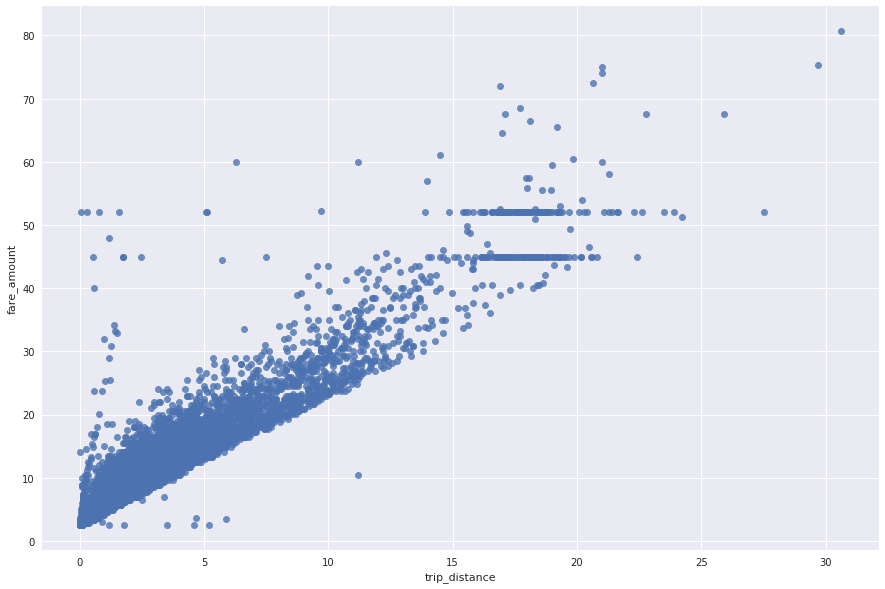

In [12]:
trips = bq.Query(afewrecords3, EVERY_N=100000).to_dataframe()
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

What's up with the streaks at <span>$</span>45 and \$50?  Those are fixed-amount rides from JFK into anywhere in Manhattan, i.e. to be expected. Let's list the data to make sure the values look reasonable.

Let's examine whether the toll amount is captured in the total amount.

In [13]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2012-09-05 15:45:00']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
232,2012-09-05 15:45:00,-73.776752,40.645120,-73.947410,40.776887,1,19.17,4.8,52.0,67.7
449,2012-09-05 15:45:00,-73.862842,40.769097,-73.864235,40.842857,1,11.47,4.8,32.5,37.8
621,2012-09-05 15:45:00,-73.961938,40.773337,-73.865820,40.769607,1,10.95,4.8,32.0,46.9
964,2012-09-05 15:45:00,-73.976282,40.751292,-73.872445,40.774442,1,8.66,4.8,24.5,33.1
1346,2012-09-05 15:45:00,-73.872895,40.774047,-73.986535,40.745427,6,8.57,4.8,28.0,38.9
2165,2012-09-05 15:45:00,-73.974837,40.758055,-73.885452,40.773130,1,11.77,4.8,34.0,46.1
2208,2012-09-05 15:45:00,-73.781918,40.644722,-73.985535,40.763272,1,18.64,4.8,52.0,57.3
2938,2012-09-05 15:45:00,-73.873162,40.774097,-73.958280,40.760662,3,8.99,4.8,27.0,37.7
3879,2012-09-05 15:45:00,-73.977698,40.765995,-74.179125,40.688890,1,17.72,9.5,68.5,78.0
5009,2012-09-05 15:45:00,-73.993160,40.758052,-73.937263,40.588857,3,19.32,4.8,53.0,68.9


Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So, we'll use the sum of fare_amount + tolls_amount as what needs to be predicted.  Tips are discretionary and do not have to be included in our fare estimation tool.

Let's also look at the distribution of values within the columns.

In [14]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000,11399.000000
mean,-72.527535,39.617912,-72.404391,39.868710,1.724362,2.835853,0.224971,10.993261,13.039932
std,18.542472,28.119500,11.568156,7.355617,1.345739,3.259306,1.102298,8.596538,10.404581
min,-1687.399757,-2895.273900,-74.417107,-444.385228,0.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992116,40.735473,-73.991602,40.733678,1.000000,1.010000,0.000000,6.000000,7.100000
50%,-73.981703,40.753037,-73.980398,40.753262,1.000000,1.740000,0.000000,8.300000,9.880000
75%,-73.966778,40.767680,-73.964292,40.768248,2.000000,3.160000,0.000000,12.500000,14.500000
max,0.009137,41.366138,443.321210,41.366138,6.000000,30.600000,19.500000,80.700000,110.680000


<h3> Quality control and other preprocessing </h3>

We need to some clean-up of the data:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>We shouldn't have zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

We could do preprocessing in SQL, similar to how we removed the zero-distance rides, but just to show you another option, let's do this in Python.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

This sort of preprocessing of input data is quite common in ML, especially if the quality-control is dynamic.

In [16]:
def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance']
  del trips['pickup_datetime']
  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

trips = bq.Query(afewrecords3, EVERY_N=10000).to_dataframe()

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,105335.000000,105335.000000,105335.000000,105335.000000,105335.000000,105335.000000
mean,-73.975261,40.751271,-73.974363,40.751657,1.676660,11.274427
std,0.040940,0.032882,0.039201,0.036926,1.290883,9.384679
min,-77.548270,37.505027,-77.528977,37.518858,1.000000,2.500000
25%,-73.992197,40.736891,-73.991502,40.736320,1.000000,6.000000
50%,-73.982033,40.753752,-73.980578,40.754292,1.000000,8.500000
75%,-73.968257,40.767753,-73.965515,40.768642,2.000000,12.500000
max,-72.910408,41.591743,-72.907598,43.703950,6.000000,133.080000


# scoring of accuracy

To compare the quality of different models we have to come up with a way to express the overall accuracy of a model. To do that we will run predictions against the same test training set and compare our predictions agains the known correct values. A simple way to aggregate all individual deviations or errors is the Root Mean Squared Error (RMSE). The calculation is

![rmse_formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/eeb88fa0f90448e9d1a67cd7a70164f674aeb300 "RMSE formula")

The benefit of RMSE is that it is easy to calculate and the result is expressed in the same unit as the predicted label. Throughout the training phase(s) the model will "fit" against the training set. We can calculate the RMSE of a model against the training set but it will usually be biased to be too optimistic as the model might be suffering from overfitting, that is it might be good at "remembering" certain outcomes in the test data or handle it's specific quirks but then underperform against real life data.
That's why it is necessary to evaluate the performance of a model against a validation set. More sophisticated ML models and neural networks have many parameters that can be tuned either by an engineer or the training process itself. In those cases, each iteration of a model training would check the results against the validation set, adjust a parameter, then retrain and see if the new parameter value improved or regressed the model's performance.

There are many options for choosing loss functions and they can have a significant impact on the performance of trained ML models. 

<h3> Create ML datasets </h3>

Let's split the QCed data randomly into training and validation sets.

In [17]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.80)
validsize = int(len(shuffled['fare_amount']) * 0.20)


df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]

In [18]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,84268.000000,84268.000000,84268.000000,84268.000000,84268.000000,84268.000000
mean,-73.975261,40.751239,-73.974341,40.751690,1.674906,11.278808
std,0.039852,0.033595,0.039186,0.036539,1.290057,9.420193
min,-77.548270,37.505027,-77.528977,37.518858,1.000000,2.500000
25%,-73.992196,40.736897,-73.991462,40.736514,1.000000,6.000000
50%,-73.982017,40.753734,-73.980530,40.754415,1.000000,8.500000
75%,-73.968315,40.767753,-73.965500,40.768728,2.000000,12.500000
max,-73.137393,41.582405,-73.137393,41.587082,6.000000,133.080000


In [19]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000,21067.000000
mean,-73.975258,40.751399,-73.974452,40.751521,1.683676,11.256904
std,0.045031,0.029862,0.039262,0.038437,1.294190,9.241457
min,-77.366665,40.277250,-75.675085,40.303627,1.000000,2.500000
25%,-73.992199,40.736843,-73.991658,40.735455,1.000000,6.000000
50%,-73.982087,40.753839,-73.980738,40.753807,1.000000,8.500000
75%,-73.968036,40.767757,-73.965584,40.768396,2.000000,12.500000
max,-72.910408,41.591743,-72.907598,43.703950,6.000000,129.300000


Let's write out the two dataframes to appropriately named csv files. We can use these csv files for local training (recall that these files represent only 1/100,000 of the full dataset) until we get to point of using Dataflow and Cloud ML.

The training set will be used to fit the model in the training phase.
Validation is for quick evaluation of the trained model, especially useful in comparing different training parameters.
It would also be best practice to have a Test dataset as the final step and used to compare different models against each other. 

In [20]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print (cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)

! mkdir -p data
to_csv(df_train, 'data/taxi-train.csv')
to_csv(df_valid, 'data/taxi-valid.csv')
#to_csv(df_test, 'data/taxi-test.csv')

['fare_amount', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', u'passenger_count', 'key']
['fare_amount', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', u'passenger_count', 'key']


In [21]:
!head -10 data/taxi-train.csv

9.3,-73.969825,40.760286,-73.982448,40.768248,1,0
7.7,-73.958347,40.764357,-73.958525,40.780832,3,1
4.5,-73.976162,40.788892,-73.979194,40.776891,1,2
14.5,-73.97797,40.754905,-73.977116,40.7874,4,3
6.5,-73.99107,40.74956,-73.991827,40.733278,1,4
9.7,-73.972181,40.76413,-73.987964,40.753378,1,5
5.3,-73.981808,40.746533,-73.988028,40.735395,5,6
5.0,-73.97555541992188,40.75211715698242,-73.98474884033203,40.73976135253906,1,7
13.3,-73.9801,40.7487,-73.979275,40.786987,1,8
7.5,-73.990307,40.756187,-73.977557,40.761062,5,9


We have 2 .csv files corresponding to training and validation.  The ratio of file-sizes correspond to our split of the data. 

Looks good! We now have our ML datasets and are ready to train ML models, validate them and evaluate them.

# rule-based Benchmark

Before we start building actual ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

The simplest model is going to be to derive the trip distance and calculate the mean rate per km (or mile). Then to predict the rate we multiply that average cost per km with the trip distance.
In the absence of a map routing engine, we will have to use the direct line between pickup and dropoff which is obviously flawed but simple and fast to calculate.

In [22]:
def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
  dist = np.degrees(np.arccos(np.minimum(1,np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  print ("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('data/taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('data/taxi-valid.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print ("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
#print_rmse(df_valid, rate, 'Valid')  

Rate = $2.56185064308/km
Train RMSE = 6.95026752448


### Benchmark on validation dataset
The RMSE depends on the dataset, and for comparison, we have to evaluate on the same dataset each time. We'll use this query in later labs:

In [23]:
print_rmse(df_valid, 2.56, 'Validation Set')

Validation Set RMSE = 12.3810786778


The simple distance-based rule gives us a RMSE of about <b>$8</b>.  We have to beat this, of course, but you will find that simple rules of thumb like this can be surprisingly difficult to beat.

Let's be ambitious, though, and make our goal to build ML models that have a RMSE of less than $6 on the test set.

# Machine Learning using Tensorflow

Tensorflow is a popular open source machine learning library. Beyond basic algorithms it supports distributed training on neural networks. We will start with a linear regression model using tf.estimator and evaluate its performance. Tensorflow can run both locally or on a remote compute cluster. We will start with a small dataset (<10k records) so we can do it all in-memory on the VM that this notebook is running on. We will also just pass the data in as-is. 

## A quick word about linear regression

The model is a simple linear equation:

y = c + a1*x1 + a2*x2 + ...

And during fitting/trainig we are trying out different weights to minimize overall loss. In the simplest form all inputs to the equation must be numerical for this to work. 

In [24]:
# In CSV, label is the first column, after the features, followed by the key
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
FEATURES = CSV_COLUMNS[1:len(CSV_COLUMNS) - 1]
LABEL = CSV_COLUMNS[0]

df_train = pd.read_csv('./data/taxi-train.csv', header = None, names = CSV_COLUMNS)
df_valid = pd.read_csv('./data/taxi-valid.csv', header = None, names = CSV_COLUMNS)

## Input function to read from Pandas Dataframe into tf

In [25]:
def make_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

### Create feature columns for estimator

In [26]:
def make_feature_cols():
  input_columns = [tf.feature_column.numeric_column(k) for k in FEATURES]
  return input_columns

<h3> Linear Regression with tf.Estimator framework </h3>

In [27]:
tf.logging.set_verbosity(tf.logging.INFO)

OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

model = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)

model.train(input_fn = make_input_fn(df_train, num_epochs = 10))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3fc92b590>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 18188.08, ste

Evaluate on the validation data (we should defer using the test data to after we have selected a final model). Let's see if the number of iterations can help to improve the training. Try out different values and calculate the RMSE for the validation set.

In [28]:
def print_rmse(model, name, df):
  metrics = model.evaluate(input_fn = make_input_fn(df, 1))
  print('RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['average_loss'])))
    
print_rmse(model, 'validation', df_valid)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-29-15:56:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-6584
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-29-15:56:23
INFO:tensorflow:Saving dict for global step 6584: average_loss = 85.44014, global_step = 6584, loss = 10908.894
RMSE on validation dataset = 9.24338340759


This is nowhere near our benchmark (RMSE of $8 or so on this data), but it serves to demonstrate what TensorFlow code looks like.  Let's use this model for prediction.

In [29]:
import itertools
# Read saved model and use it for prediction
model = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
preds_iter = model.predict(input_fn = make_input_fn(df_valid, 1))
print([pred['predictions'][0] for pred in list(itertools.islice(preds_iter, 10))])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3f072dbd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-6584
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[11.032484, 11.338317, 11.184893, 11.032039, 11.031417, 11.032532, 11.339086, 11

This explains why the RMSE was so high -- the model essentially predicts the same amount for every trip.  Would a more complex model help? Let's try using a deep neural network.  The code to do this is quite straightforward as well.

# Deep Neural Network regression

http://playground.tensorflow.org

In [30]:
tf.logging.set_verbosity(tf.logging.INFO)
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
model = tf.estimator.DNNRegressor(hidden_units = [32, 8, 2],
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
model.train(input_fn = make_input_fn(df_train, num_epochs = 20));

print_rmse(model, 'valid', df_valid)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3f0628790>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'taxi_trained', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into taxi_trained/model.ckpt.
INFO:tensorflow:loss = 28600.762, st

INFO:tensorflow:global_step/sec: 165.945
INFO:tensorflow:loss = 12932.879, step = 7401 (0.602 sec)
INFO:tensorflow:global_step/sec: 231.035
INFO:tensorflow:loss = 10645.579, step = 7501 (0.433 sec)
INFO:tensorflow:global_step/sec: 163.959
INFO:tensorflow:loss = 8514.432, step = 7601 (0.612 sec)
INFO:tensorflow:global_step/sec: 227.918
INFO:tensorflow:loss = 10913.953, step = 7701 (0.437 sec)
INFO:tensorflow:global_step/sec: 161.664
INFO:tensorflow:loss = 10905.918, step = 7801 (0.619 sec)
INFO:tensorflow:global_step/sec: 227.86
INFO:tensorflow:loss = 11600.424, step = 7901 (0.439 sec)
INFO:tensorflow:global_step/sec: 166.566
INFO:tensorflow:loss = 19522.281, step = 8001 (0.602 sec)
INFO:tensorflow:global_step/sec: 223.232
INFO:tensorflow:loss = 7959.359, step = 8101 (0.449 sec)
INFO:tensorflow:global_step/sec: 164.618
INFO:tensorflow:loss = 22047.902, step = 8201 (0.604 sec)
INFO:tensorflow:global_step/sec: 239.499
INFO:tensorflow:loss = 9085.92, step = 8301 (0.418 sec)
INFO:tensorflow

We are not beating our benchmark with either model ... what's up?  Well, we may be using TensorFlow for Machine Learning, but we are not yet using it well.  That's what the rest of this session is about!

RMSE on benchmark dataset is > $10 (results will vary because of random seeds).

This is not only way more than our goal of 6.00, but it doesn't even beat our distance-based rule's RMSE of 8.

Fear not -- you have learned how to write a TensorFlow model, but not to do all the things that you will have to do to your ML model performant. We will do this in the next chapters. In this chapter though, we will get our TensorFlow model ready for these improvements.

# Improving ML

## better data: Feature engineering

### Day of week

* date is available for training and inference
* exact date (YYYY-MM-DD) is not that useful as we would have different values between training and inference
* but we can extract the day of the week and there is likely a correlation between traffic on different dates
* It's also important to note that this should not be a numerical feature. day=4 is not any better than day=2
* We can code the dow as a categorical feature which will turn one input into 7 distinct features

### Hour of Day

* the pickup time likely also has an impact on traffic and fares (we know that there are time-based surcharges)
* but we also know that there is likely not much difference between a pickup at 12:30 vs 12:42
* so let's settle on coding the hour of the day as another category
* furthermore we can create a feature-cross between hour-of-day and day-of-week

### distance

* we saw from our initial benchmark that the euclidian distance is a feature with a strong correlation
* that distance can easily be calculated from the input long/lat values

### pickup and dropoff

* our dataset has very (too?) accurate location data
* but we know that if pickup and dropoff are within a few city blocks, the fare should be about the same
* an extra challenge we do not address: bridges and tolls
* what we can easily do is to create a grid of buckets over the city's coordinates
* we can make that a tunable parameter, starting with a 10x10 grid
* additionally let's add a feature-cross of pickup and dropoff so that we can group similar trips together

## hyperparameter tuning

* we already saw that the layout of neurons plays a great role in finding the best DNN
* likewise a different number of buckets for the location grid can have an impact
* we are going to search for the optimal values

## more data: scale to cloud training

* DNNs generally create better predictions the larger the training dataset becomes
* we will perform a few dry-runs locally
* and then increase the amount of training data and fit on a cluster of machines in the cloud

In [31]:
PROJECT = 'rostlab-181304'    # CHANGE THIS
BUCKET = 'rostlab-181304-ml' # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
REGION = 'us-central1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.

In [32]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8' 

In [33]:
%%bash
## ensure gcloud is up to date
gcloud components update

gcloud config set project $PROJECT
gcloud config set compute/region $REGION

## ensure we predict locally with our current Python environment
gcloud config set ml_engine/local_python `which python`



Your current Cloud SDK version is: 212.0.0
You will be upgraded to version: 226.0.0

+----------------------------------------------------------------------------+
|                     These components will be updated.                      |
+-----------------------------------------------------+------------+---------+
|                         Name                        |  Version   |   Size  |
+-----------------------------------------------------+------------+---------+
| BigQuery Command Line Tool                          |     2.0.38 | < 1 MiB |
| BigQuery Command Line Tool (Platform Specific)      |     2.0.34 | < 1 MiB |
| Cloud SDK Core Libraries                            | 2018.11.16 | 9.0 MiB |
| Cloud SDK Core Libraries (Platform Specific)        | 2018.09.24 | < 1 MiB |
| Cloud Storage Command Line Tool                     |       4.34 | 3.5 MiB |
| Cloud Storage Command Line Tool (Platform Specific) |       4.34 | < 1 MiB |
| gcloud Alpha Commands                     

## Develop model with new inputs

Download the first shard of a preprocessed data to enable local development. We could create these files ourselves but they are also available on a public bucket.

In [34]:
%%bash
if [ -d sample ]; then
  rm -rf sample
fi
mkdir sample

gsutil cat "gs://cloud-training-demos/taxifare/train.csv-00000-of-*" > sample/train.csv
gsutil cat "gs://cloud-training-demos/taxifare/valid.csv-00000-of-*" > sample/valid.csv
wc -l sample/*

  23289 sample/train.csv
  58506 sample/valid.csv
  81795 total


We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [35]:
%%bash
grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """


In [ ]:
%%bash
grep -A 50 "build_estimator" taxifare/trainer/model.py

In [ ]:
%%bash
grep -A 15 "add_engineered(" taxifare/trainer/model.py

In [36]:
%%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
python -m trainer.task \
  --train_data_paths=${PWD}/sample/train.csv \
  --eval_data_paths=${PWD}/sample/valid.csv  \
  --output_dir=${PWD}/taxi_trained \
  --train_steps=10 \
  --job-dir=/tmp

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4bc5767cd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/content/datalab/ml-live/taxi_trained/', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
IN

In [37]:
print('RMSE = {}'.format(np.sqrt(80)))

RMSE = 8.94427191


You can use ```saved_model_cli``` to look at the exported signature. Note that the model doesn't need any of the engineered features as inputs. It will compute latdiff, londiff, euclidean from the provided inputs, thanks to the ```add_engineered``` call in the serving_input_fn.

In [38]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter | tail -1)
saved_model_cli show --dir ${PWD}/taxi_trained/export/exporter/${model_dir} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dayofweek'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: Placeholder_8:0
    inputs['dropofflat'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_2:0
    inputs['dropofflon'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_3:0
    inputs['euclidean'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_7:0
    inputs['hourofday'] tensor_info:
        dtype: DT_INT32
        shape: (-1)
        name: Placeholder_9:0
    inputs['latdiff'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_5:0
    inputs['londiff'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: Placeholder_6:0
    inputs['passengers'] tensor_info:
        dtype: D

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [39]:
%%writefile /tmp/test.json
{"dayofweek": "Sun", "hourofday": 17, "pickuplon": -73.885262, "pickuplat": 40.773008, "dropofflon": -73.987232, "dropofflat": 40.732403, "passengers": 2}

Writing /tmp/test.json


In [40]:
%%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter)
echo ${PWD}/taxi_trained/export/exporter/${model_dir}
gcloud ml-engine local predict \
  --model-dir=${PWD}/taxi_trained/export/exporter/${model_dir} \
  --json-instances=/tmp/test.json

/content/datalab/ml-live/taxi_trained/export/exporter/1543508352
PREDICTIONS
[8.145706176757812]


  from ._conv import register_converters as _register_converters
2018-11-29 16:20:24.025049: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA



## 5. Train on cloud

This will take <b> 5-10 minutes </b> even though the prompt immediately returns after the job is submitted. Monitor job progress on the [Cloud Console, in the ML Engine](https://console.cloud.google.com/mlengine) section and wait for the training job to complete.

In [41]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/taxi_trained
JOBNAME=ml_live_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/taxifare/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=$TFVERSION \
  -- \
  --train_data_paths="gs://cloud-training-demos/taxifare/train.csv-00001-of-*" \
  --eval_data_paths="gs://cloud-training-demos/taxifare/valid.csv-00000-of-*"  \
  --train_steps=5000 \
  --output_dir=$OUTDIR

gs://rostlab-181304-ml/taxifare/taxi_trained us-central1 ml_live_181129_162052
jobId: ml_live_181129_162052
state: QUEUED


Removing gs://rostlab-181304-ml/taxifare/taxi_trained/#1540229684199755...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/checkpoint#1540229687052654...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/eval/#1540229602023024...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/eval/events.out.tfevents.1540229602.cmle-training-master-08cdee42fa-0-pljx8#1540229698273119...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/events.out.tfevents.1540229493.cmle-training-master-08cdee42fa-0-pljx8#1540229688351052...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/export/#1540229605235278...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/export/exporter/#1540229605432151...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/export/exporter/1540229604/#1540229609883017...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/export/exporter/1540229604/saved_model.pb#1540229610047448...
Removing gs://rostlab-181304-ml/taxifare/taxi_trained/export/exporter/1540

The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

<b>Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.</b>

# Hyper-parameter tune

Training a DNN supports a number of parameters such as the number of hidden layers, training batch size etc. These have a significant impact on a model's performance. Hypertuning is the process of iteratively trying out several options to come up with the optimal values.

## Command-line parameters to task.py

Note the command-line parameters to task.py.  These are the things that could be hypertuned if we wanted.

In [44]:
!grep -A 2 add_argument taxifare/trainer/task.py

    parser.add_argument(
        '--train_data_paths',
        help = 'GCS or local path to training data',
--
    parser.add_argument(
        '--train_batch_size',
        help = 'Batch size for training steps',
--
    parser.add_argument(
        '--eval_batch_size',
        help = 'Batch size for evaluation steps',
--
    parser.add_argument(
        '--train_steps',
        help = 'Steps to run the training job for',
--
    parser.add_argument(
        '--eval_steps',
        help = 'Number of steps to run evalution for at each checkpoint',
--
    parser.add_argument(
        '--eval_data_paths',
        help = 'GCS or local path to evaluation data',
--
    parser.add_argument(
        '--nbuckets',
        help = 'Number of buckets into which to discretize lats and lons',
--
    parser.add_argument(
        '--hidden_units',
        help = 'Hidden layer sizes to use for DNN feature columns -- provide space-separated layers',
--
    parser.add_argument(
        '--output_dir',
   

## Evaluation metric

We add a special evaluation metric. It could be any objective function we want.

In [45]:
!grep -A 5 get_eval_metrics taxifare/trainer/model.py

def get_eval_metrics():
    return {
        'rmse': tflearn.MetricSpec(metric_fn=metrics.streaming_root_mean_squared_error),
        'training/hptuning/metric': tflearn.MetricSpec(metric_fn=metrics.streaming_root_mean_squared_error),
    }


## Add trial id to not overwrite existing results

In [1]:
!grep -A 5 "trial" taxifare/trainer/task.py

    # Append trial_id to path if we are doing hptuning
    # This code can be removed if you are not using hyperparameter tuning
    output_dir = os.path.join(
        output_dir,
        json.loads(
            os.environ.get('TF_CONFIG', '{}')
        ).get('task', {}).get('trial', '')
    )

    # Run the training job:
    try:
        model.train_and_evaluate(arguments)


## Create hyper-parameter configuration

The file specifies the search region in parameter space.  Cloud MLE carries out a smart search algorithm within these constraints (i.e. it does not try out every single value).

In [48]:
%writefile hyperparam.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    goal: MINIMIZE
    maxTrials: 30
    maxParallelTrials: 3
    hyperparameterMetricTag: rmse
    params:
    - parameterName: train_batch_size
      type: INTEGER
      minValue: 64
      maxValue: 512
      scaleType: UNIT_LOG_SCALE
    - parameterName: nbuckets
      type: INTEGER
      minValue: 10
      maxValue: 20
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: hidden_units
      type: CATEGORICAL
      categoricalValues: ["128 32", "256 128 16", "64 64 64 8"]       

Overwriting hyperparam.yaml


## Run the HP training job
we just add the new HP config to the existing job

In [49]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/taxi_hypertrain
JOBNAME=ml_live_hp_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=STANDARD_1 \
   --runtime-version=$TFVERSION \
   --config=hyperparam.yaml \
   -- \
   --train_data_paths="gs://$BUCKET/taxifare/taxi_preproc/train.csv-00000-of-*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/taxi_preproc/valid.csv-00000-of-*"  \
   --output_dir=$OUTDIR \
   --train_steps=5000

gs://rostlab-181304-ml/taxifare/taxi_hypertrain us-central1 ml_live_hp_181129_163719
jobId: ml_live_hp_181129_163719
state: QUEUED


Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/#1540338086921340...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/#1540338330321966...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/checkpoint#1540338333009717...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/eval/#1540338301998629...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/eval/events.out.tfevents.1540338302.cmle-training-master-ad6dba1140-0-nllrl#1540338403839862...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/events.out.tfevents.1540338087.cmle-training-master-ad6dba1140-0-nllrl#1540338334404719...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/export/#1540338305943337...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/export/exporter/#1540338306200097...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/export/exporter/1540338304/#1540338311517310...
Removing gs://rostlab-181304-ml/taxifare/taxi_hypertrain/1/export/export

## start tensorboard

In [50]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/taxi_hypertrain'.format(BUCKET)
print(OUTDIR)
TensorBoard().start(OUTDIR)

gs://rostlab-181304-ml/taxifare/taxi_hypertrain


TensorBoard was started successfully with pid 8429. Click here to access it.

8429

## stop tensorboard

In [47]:
pids_df = TensorBoard.list()
if not pids_df.empty:
    for pid in pids_df['pid']:
        TensorBoard().stop(pid)
        print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 7994


Based on this we come up with these values for our training parameters:

* train_batch_size: 512
* nbuckets: 16
* hidden_units: "64 64 64 8"


# Run with optimal hyperparameters

In [ ]:
%%bash

OUTDIR=gs://${BUCKET}/taxifare/feateng
JOBNAME=mllive_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
#gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://cloud-training-demos/taxifare/train.csv-00001-of-*" \
   --eval_data_paths="gs://cloud-training-demos/taxifare/valid.csv-00000-of-*"  \
   --output_dir=$OUTDIR \
   --train_steps=8000 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

This yields an RMSE of about \$5. Beating our first benchmark. But let's try this on a larger dataset and see how far we can push it.

# Run on large dataset with 2M records

In [ ]:
%%bash

#WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=mllivexl_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
#gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://cloud-training-demos/taxifare/train*" \
   --eval_data_paths="gs://cloud-training-demos/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=1600000 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

### Start Tensorboard

In [38]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print(OUTDIR)
TensorBoard().start(OUTDIR)

gs://rostlab-181304-ml/taxifare/feateng2m


TensorBoard was started successfully with pid 5516. Click here to access it.

5516

### Stop Tensorboard

In [ ]:
pids_df = TensorBoard.list()
if not pids_df.empty:
    for pid in pids_df['pid']:
        TensorBoard().stop(pid)
        print('Stopped TensorBoard with pid {}'.format(pid))

The RMSE after training on the 2-million-row dataset is \$3.03.  This graph shows the improvements so far ...

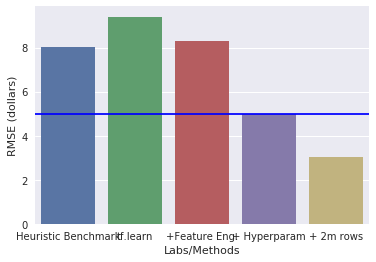

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

# ML in Oracle products

* Oracle Data Mining
* Oracle Analytics Cloud Service
* Oracle Data Science Cloud (datascience.com acquisition) - coming soon

# References

This notebook is based on labs from an excellent [coursera class](https://www.coursera.org/learn/serverless-machine-learning-gcp) that is a great starting point to learn about machine learning with tensorflow in the cloud.

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License